# 2-5. 프로젝트: SentencePiece 사용하기


# 1. 네이버 영화리뷰 데이터 수집 (공통) 

In [1]:
#!cp -r ~/aiffel/sentiment_classification/data ~/aiffel/sp_tokenizer/data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import konlpy
from konlpy.tag import Mecab, Kkma, Okt, Komoran, Hannanum 
import gensim
from collections import Counter
import os,sys,copy,time
import seaborn as sns
import tqdm
import re
import urllib

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)
print(pd.__version__)
print(gensim.__version__)

2.6.0
1.21.4
0.5.2
1.3.3
4.1.2


In [2]:
url_train = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
url_test = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"

urllib.request.urlretrieve(url_train, filename="ratings_train.txt")
urllib.request.urlretrieve(url_test, filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f81284ea3a0>)

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table(r'~/aiffel/sp_tokenizer/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_test.txt')

print("train_data",train_data.head(),train_data.shape)
print('-'*60)
print("test_data",test_data.head(),test_data.shape)

train_data          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1 (150000, 3)
------------------------------------------------------------
test_data         id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0 (50000, 3)


# 2. SentencePiece 토크나이저 사용의 경우

* **(1) 데이터 기본적 전처리**

In [4]:
## 데이터로더
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
voca_size =10000

def load_and_preprocess_data(train_data, test_data, voca_size = voca_size):
    ## 중복값 제거:  'document'컬럼의 중복값 제거,'label'컬럼은 0,1의 두개면 맞음
    #1. train_data
    print("train_data['document'].nunique()",train_data['document'].nunique())
    if train_data['document'].nunique() < len(train_data):
        train_data.drop_duplicates(subset=['document'], inplace=True) 
        print("train_data['label'].nunique()",train_data['label'].nunique())    
        print("중복제거후 len(train_data)",len(train_data))    
    #2. test_data    
    print("test_data['document'].nunique()",test_data['document'].nunique())
    if test_data['document'].nunique() < len(test_data):
        test_data.drop_duplicates(subset=['document'], inplace=True)
        print("test_data['label'].nunique()",test_data['label'].nunique())    
        print("중복제거후 len(test_data)",len(test_data))
    
    ## 결측치제거 : 1개라도 있으면, 해당행 전체 제거
    #1. train_data
    print("결측치 개수",train_data.isnull().sum())
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",train_data.isnull().any().any())    
    #2. test_data
    print("결측치 개수",test_data.isnull().sum())
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",test_data.isnull().any().any())
    
    ## 데이터 정제 
    # 한글과 숫자,공백(한개이상 공백은 한개로 축소),특수문자일부 !?,.^을 제외하고 제거:[^ㄱ-힣a-zA-Z0-9!?,.^\s]
    # --> 한글형태소기를 tokenizer로 쓸 경우에는 영어및 일부선택된 특수문자외에는 모두제거(..., - - 등도 제거)
    #1. train_data
    train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
    train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ") 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                         
    print("한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()",train_data.head())
    #2. test_data
    test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
    test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ") 
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                            
    print("한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()",test_data.head())
    # 데이터 정제후 빈 공백만 있는 문장의 경우 제거:  Nan 입력후 행제거
    #1. train_data
    train_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",train_data.isnull().any().any() )
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
    #2. test_data   
    test_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",test_data.isnull().any().any() )
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
    
    # X_train , y_train, X_test, y_test    
    X_train = train_data['document']
    y_train = np.array(train_data['label'].tolist())
    X_test = test_data['document']
    y_test = np.array(test_data['label'].tolist())
    
    return X_train, y_train, X_test, y_test
    
        
X_train, y_train, X_test, y_test = load_and_preprocess_data(train_data, test_data)

# 전처리된 데이터 확인(불용어처리는 않되었슴, 형태소분석후 해야하는데, sentencepiece는 학습중에
# --> 처리될수도 있으나, 확실치 않으니, 결과를 반드시 확인해야함, 형태소분석을 해야하는 한국어인데,
# sentencepiece에서는 않해도 되는지 확인필요)
print("X_train[:5]",X_train[:5],"y_train[:5]",y_train[:5],"X_test[:5]",X_test[:5],"y_test[:5]",y_test[:5])



train_data['document'].nunique() 146182
train_data['label'].nunique() 2
중복제거후 len(train_data) 146183
test_data['document'].nunique() 49157
test_data['label'].nunique() 2
중복제거후 len(test_data) 49158
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False


/tmp/ipykernel_3107/3168550979.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_3107/3168550979.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_3107/3168550979.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()          id                                           document  label
0   9976970                                 아 더빙  진짜 짜증나네요 목소리      0
1   3819312                       흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                        교도소 이야기구먼  솔직히 재미는 없다 평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


/tmp/ipykernel_3107/3168550979.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_3107/3168550979.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_3107/3168550979.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()         id                                        document  label
0  6270596                                             굳 ㅋ      1
1  9274899                                                      0
2  8544678             뭐야 이 평점들은  나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                     지루하지는 않은데 완전 막장임  돈주고 보기에는       0
4  6723715  3만 아니었어도 별 다섯 개 줬을텐데  왜 3로 나와서 제 심기를 불편하게 하죠??      0
Nan 존재유뮤 True
Nan 존재유뮤 True
X_train[:5] 0                                   아 더빙  진짜 짜증나네요 목소리
1                         흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                          교도소 이야기구먼  솔직히 재미는 없다 평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object y_train[:5] [0 1 0 0 1] X_test[:5] 0                                               굳 ㅋ
2               뭐야 이 평점들은  나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                       지루하지는 않은데 완전 막장임  돈주고 보기에는 
4    3만 아니었어도 별 다섯 개 줬을텐데  

In [5]:
print("X_train.shape",X_train.shape,"y_train.shape",y_train.shape,"X_test.shape",X_test.shape,"y_test.shape",y_test.shape)

X_train.shape (146026,) y_train.shape (146026,) X_test.shape (49084,) y_test.shape (49084,)


**[체크필요]: 위에서 불용어처리는 않되었슴**
형태소분석후 해야하는데, Sentencepiece는 학습중에 처리될수도 있으나, 확실치 않으니, 결과를 반드시 확인해야함, 형태소분석을 해야하는 한국어인데,
Sentencepiece에서는 않해도 되는지 확인필요

#### (2) Sentencepiece 로 1차 Tokenizing
* **maxlen 지정전 train data 로 1차 Tokenizing 학습**

In [9]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram.txt'
print(temp_file)

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in X_train: 
        f.write(str(row) + '\n')

## SentencePieceTrainer 실행: 1차 실행 (maxlen인자 없이)
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram --vocab_size={} --model_type=unigram'.format(temp_file, vocab_size)   
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

/aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram.txt


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram.txt --model_prefix=korean_spm_unigram --vocab_size=10000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram.txt
  input_format: 
  model_prefix: korean_spm_unigram
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 

-rw-r--r-- 1 root root 416992 Feb 18 00:55 korean_spm_bpe.model
-rw-r--r-- 1 root root 409870 Feb 18 00:38 korean_spm_bpe_new.model
-rw-r--r-- 1 root root 151059 Feb 18 00:38 korean_spm_bpe_new.vocab
-rw-r--r-- 1 root root 188138 Feb 18 00:55 korean_spm_bpe.vocab
-rw-r--r-- 1 root root 416996 Feb 18 00:58 korean_spm_unigram.model
-rw-r--r-- 1 root root 188138 Feb 18 00:58 korean_spm_unigram.vocab


In [10]:
"""
input : 학습시킬 파일
model_prefix : 만들어질 모델 이름
vocab_size : 단어 집합의 크기
model_type : 사용할 모델 (unigram(default), bpe, char, word)
max_sentence_length: 문장의 최대 길이
pad_id, pad_piece: pad token id, 값
unk_id, unk_piece: unknown token id, 값
bos_id, bos_piece: begin of sentence token id, 값
eos_id, eos_piece: end of sequence token id, 값
user_defined_symbols: 사용자 정의 토큰
"""

'\ninput : 학습시킬 파일\nmodel_prefix : 만들어질 모델 이름\nvocab_size : 단어 집합의 크기\nmodel_type : 사용할 모델 (unigram(default), bpe, char, word)\nmax_sentence_length: 문장의 최대 길이\npad_id, pad_piece: pad token id, 값\nunk_id, unk_piece: unknown token id, 값\nbos_id, bos_piece: begin of sentence token id, 값\neos_id, eos_piece: end of sequence token id, 값\nuser_defined_symbols: 사용자 정의 토큰\n'

In [11]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_unigram.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1184, 9, 486, 13, 1277, 9, 150, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


* **sp_tokenize_noPadding 함수 생성**

In [12]:
def sp_tokenize_noPadding(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_unigram.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    return tensor, word_index, index_word

In [13]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize_noPadding(s, my_corpus)
print(tensor)

[[488, 3072, 12, 1028, 2471, 4], [1199, 2168, 184, 601, 9, 3, 14, 9937, 1070, 4, 4, 4]]


* **1차 학습된 spm으로 sp_tokenize함수를 통해 X_train,  X_test 각각 토크나이징**

In [14]:
# X_train, y_train, X_test, y_test

# Tokenizing: X_train 
X_train_tensor, X_train_word_index, X_train_index_word = sp_tokenize_noPadding(s, X_train)
print("X_train_tensor[:10]",X_train_tensor[:10])

# Tokenizing: X_test 
X_test_tensor, X_test_word_index, X_test_index_word = sp_tokenize_noPadding(s, X_test)
print("X_test_tensor[:10]",X_test_tensor[:10])

X_train_tensor[:10] [[54, 915, 27, 1869, 62, 1593], [1444, 951, 153, 1370, 31, 322, 2549, 419, 1172, 7391, 725, 421], [19, 396, 9797, 403, 6390, 135, 6284, 1789, 306], [2100, 8, 233, 217, 7073, 288, 1084, 106, 71, 7901], [2036, 5779, 2161, 198, 7, 3, 1519, 328, 2117, 433, 3712, 1788, 6, 22, 73, 442, 5, 254, 1010, 53, 6356, 2047, 1119, 2358, 2746, 6460, 3, 144, 770, 9, 1939, 3, 3736, 135, 652], [642, 540, 81, 169, 3, 0, 126, 174, 281, 5449, 47, 4016, 384, 38, 476, 328, 215, 31, 4, 279, 6245, 8, 1392, 4], [3511, 6528, 473, 3385, 226, 18, 527, 195, 4], [221, 3635, 218, 7208, 24, 2403, 391, 976, 215, 132, 72, 4092, 5, 4790, 170, 305, 23, 3067, 684, 2731, 853, 2488, 4064, 7939, 4, 282, 758, 25, 491, 1257, 491, 1257, 4868, 10, 927, 8, 520, 72, 4784, 716, 25, 304, 3061, 43], [1960, 3344, 8, 185, 108, 9392, 6], [3189, 152, 1526, 1238, 17, 903, 8101, 2625, 289, 8841, 5570, 19, 976, 57, 127, 603, 2675, 17]]
X_test_tensor[:10] [[2465, 219], [1124, 24, 71, 417, 8261, 3077, 66, 36, 6811, 10, 7707, 

#### (3) 적절한 최대 문장 길이 지정: (평균 + 표준편차*2)이내: maxlen 42 개**

문장길이평균: 15.63
문장길이표준편차: 13.67
문장길이Max: 115
문장길이Min: 0
문장길이 0개수: 308
['sans-serif']


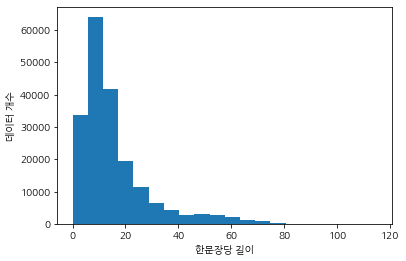

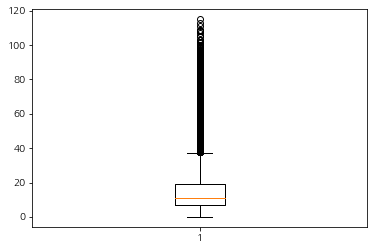

maxlen 42


In [15]:
## 데이터셋 내 문장 길이 분포
total_data_text = list(X_train_tensor) + list(X_test_tensor)
total_data_text_dist = [len(x) for x in total_data_text]
#print(total_data_text_dist)

mean = round(np.mean(total_data_text_dist),2)
std = round(np.std(total_data_text_dist),2)
max = np.max(total_data_text_dist)
min = np.min(total_data_text_dist)
min_count = len([x for x in total_data_text_dist if x == 0])
print("문장길이평균:",mean)
print("문장길이표준편차:",std)
print("문장길이Max:",max)
print("문장길이Min:",min)
print("문장길이 0개수:", min_count)

# 히스토그램 시각화: total_data
print(plt.rcParams['font.family'])
plt.rc('font',family='NanumGothic')
plt.hist(total_data_text_dist, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

# 박스플롯: total_data
plt.boxplot(total_data_text_dist)
plt.show()

## 적절한 최대 문장 길이 지정: (평균 + 표준편차*2)
maxlen = int(mean + 2*std)
print("maxlen", maxlen)

#### (4) Sentencepiece 로  최종 Tokenizing
* **maxlen 지정후 train data 로 최종 Tokenizing 학습** 

In [16]:
import sentencepiece as spm

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram_new.txt'
print(temp_file)

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in X_train: 
        f.write(str(row) + '\n')

## SentencePieceTrainer 실행: 1차 실행 (maxlen인자 없이)
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram_new --vocab_size={} --max_sentence_length={} --model_type=unigram'.format(
        temp_file, vocab_size, maxlen)   
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

/aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram_new.txt


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram_new.txt --model_prefix=korean_spm_unigram_new --vocab_size=10000 --max_sentence_length=42 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/NaverMovie_trainCorpus_temp_unigram_new.txt
  input_format: 
  model_prefix: korean_spm_unigram_new
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 42
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_sc

-rw-r--r-- 1 root root 416992 Feb 18 00:55 korean_spm_bpe.model
-rw-r--r-- 1 root root 409870 Feb 18 00:38 korean_spm_bpe_new.model
-rw-r--r-- 1 root root 151059 Feb 18 00:38 korean_spm_bpe_new.vocab
-rw-r--r-- 1 root root 188138 Feb 18 00:55 korean_spm_bpe.vocab
-rw-r--r-- 1 root root 416996 Feb 18 00:58 korean_spm_unigram.model
-rw-r--r-- 1 root root 420291 Feb 18 01:00 korean_spm_unigram_new.model
-rw-r--r-- 1 root root 191454 Feb 18 01:00 korean_spm_unigram_new.vocab
-rw-r--r-- 1 root root 188138 Feb 18 00:58 korean_spm_unigram.vocab


* **sp_tokenize_withPadding 함수 생성**

In [17]:
def sp_tokenize_withPadding(s, corpus, maxlen):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_unigram_new.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen= maxlen, padding='post')

    return tensor, word_index, index_word

In [18]:
## 새롭게 학습한 모델로 s객체 변경:및 new 모델로드  SentencePieceProcessor()
s = spm.SentencePieceProcessor()
s.Load('korean_spm_unigram_new.model')

True

* **최종 학습된 spm으로 sp_tokenize함수를 통해 X_train,  X_test 각각 토크나이징**

In [19]:
# X_train, y_train, X_test, y_test

# Tokenizing: X_train 
X_train_tensor, X_train_word_index, X_train_index_word = sp_tokenize_withPadding(s, X_train, maxlen)
print("X_train_tensor[:10]",X_train_tensor[:10])

# Tokenizing: X_test 
X_test_tensor, X_test_word_index, X_test_index_word = sp_tokenize_withPadding(s, X_test, maxlen)
print("X_test_tensor[:10]",X_test_tensor[:10])

X_train_tensor[:10] [[  26  869   15 1294   96 2046    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 379  623  307  998   27  484 3198  579 1595  188 9971   22  941  311
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  12  756 9544  424 2359   64 1221  438   18 1376  313    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [5420   16  297  206 2275  205  570   62   48 2902    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [3218 5576 3026  371    8    3 1886  811  106  782  486 6606 4101    5
     6  106  602    7  292 1514  128    

* **토크나이징 최종완료후 데이터 shape 확인**

In [20]:
print("X_train_tensor.shape",X_train_tensor.shape,"y_train.shape",y_train.shape,"X_test_tensor.shape",X_test_tensor.shape,"y_test.shape",y_test.shape)


X_train_tensor.shape (146026, 42) y_train.shape (146026,) X_test_tensor.shape (49084, 42) y_test.shape (49084,)


#### (5) 모델 구성 및 validation set 구성¶

In [21]:
## Hyper param 설정
vocab_size = len(X_train_word_index)   # 어휘 사전의 크기(8000 )#10,000개의 단어)

word_vector_dim = 16  # 워드 벡터의 차원 수
hidden_unit = 16
drop_rate = 0.2
epochs= 20 

#cnn_dense_hidden_unit = 8
#cnn_filter = 7
#cnn_maxpool = 4
epochs= 20 


* **LSTM 모델**

In [22]:
## LSTM 모델

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.LSTM(hidden_unit)) 
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.Dense(hidden_unit, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 162,401
Trainable params: 162,401
Non-trainable params: 0
__________________________________________________

* **valid data 분리**

In [23]:
## 총 train data : 80:20 
print("X_train_tensor 총개수:", len(X_train_tensor), "80%분리: ",int(len(X_train_tensor)*0.8), "20%분리:",len(X_train_tensor)-int(len(X_train_tensor)*0.8))
train_len = int(len(X_train_tensor)*0.8)
valid_len = len(X_train_tensor)-int(len(X_train_tensor)*0.8)

# validation set 20% 분리: 
X_val_tensor = X_train_tensor[:valid_len]   
y_val = y_train[:valid_len]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train_tensor[valid_len:]  
partial_y_train = y_train[valid_len:]

print("partial_X_train",len(partial_X_train),"partial_y_train",len(partial_y_train))
print("X_val_tensor",len(X_val_tensor), "y_val",len(y_val))

X_train_tensor 총개수: 146026 80%분리:  116820 20%분리: 29206
partial_X_train 116820 partial_y_train 116820
X_val_tensor 29206 y_val 29206


#### (6) LSTM모델 학습

In [24]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
  
history_lstm = model_lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val_tensor, y_val), verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.6091 - accuracy: 0.6209 - val_loss: 0.3943 - val_accuracy: 0.8252
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3673 - accuracy: 0.8420 - val_loss: 0.3494 - val_accuracy: 0.8465
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3290 - accuracy: 0.8602 - val_loss: 0.3387 - val_accuracy: 0.8506
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3133 - accuracy: 0.8666 - val_loss: 0.3383 - val_accuracy: 0.8511
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3033 - accuracy: 0.8700 - val_loss: 0.3503 - val_accuracy: 0.8434
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2933 - accuracy: 0.8743 - val_loss: 0.3511 - val_accuracy: 0.8494
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2850 - accuracy: 0.8768 - val_loss: 0.3467 - val_accuracy: 0.8516
Epoch 

* **SentencePiece의 경우 LSTM Loss, Accuracy 시각화**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


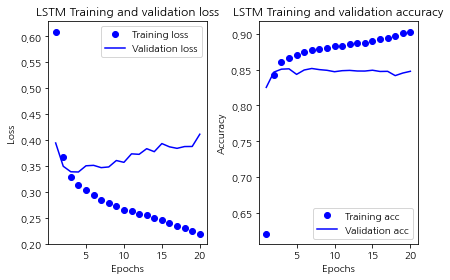

In [25]:
history_lstm = history_lstm.history
print(history_lstm.keys()) 

acc = history_lstm['accuracy']
val_acc = history_lstm['val_accuracy']
loss = history_lstm['loss']
val_loss = history_lstm['val_loss']

epochs = range(1, len(acc) + 1)

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACCURACY
#plt.clf()   # 그림을 초기화합니다
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### (7) test data 로 모델 성능평가

In [26]:
## LSTM 모델 성능평가
results_lstm = model_lstm.evaluate(X_test_tensor,  y_test, verbose=2)

print("results_lstm", results_lstm)

1534/1534 - 3s - loss: 0.4204 - accuracy: 0.8433
results_lstm [0.42039772868156433, 0.8432890772819519]


#### [Unigram SentencePiece 평가] Unigram SentencePiece의 경우 LSTM test accuracy 84.32% 였슴

###  (8)  Bpe  (Byte Pair Encoding)  Model Type로 했을 경우 :
상세 작업과정은 아래 깃허브파일을 참조

*  **bpe GitHub 링크** : https://github.com/lkh-7/first-repository/blob/master/%5BGDeep%5D02_%5Bsp_tokenizer%5D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%A9%8B%EC%A7%84%20%EB%8B%A8%EC%96%B4%EC%82%AC%EC%A0%84%20%EB%A7%8C%EB%93%A4%EA%B8%B0_Project_%EC%A0%9C%EC%B6%9C%EC%A4%80%EB%B9%84%EC%9A%A9_SPM_Bpe_ONLY.ipynb

#### [평가] bpe SentencePiece의 경우 LSTM test accuracy 83.64 % 였슴



### (9) [ Unigram  vs. bpe SentencePiece 성능 비교평가]
**Unigram** 이 **test accuracy 84.32%** 로서, bpe 83.64% 보다   LSTM Model test accuracy 에서  성능이 큰차이는 아니지만 **더 우수했슴**

# 3. Konlpy 토크나이저 사용의 경우

* **Mecab, Kkma, Okt 와 비교**

####  (1) 데이터 로드

In [27]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table(r'~/aiffel/sp_tokenizer/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_test.txt')

print("train_data",train_data.head(),train_data.shape)
print('-'*60)
print("test_data",test_data.head(),test_data.shape)

train_data          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1 (150000, 3)
------------------------------------------------------------
test_data         id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0 (50000, 3)


####  (2) Mecab

* **데이터 전처리,형태소분석,Tokenizer 함수생성 및 word_to_index, index_to_word 관련 함수생성**


In [28]:
## 데이터로더
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words=10000

def load_data(train_data, test_data, num_words=num_words):
    ## 중복값 제거:  'document'컬럼의 중복값 제거,'label'컬럼은 0,1의 두개면 맞음
    #1. train_data
    print("train_data['document'].nunique()",train_data['document'].nunique())
    if train_data['document'].nunique() < len(train_data):
        train_data.drop_duplicates(subset=['document'], inplace=True) 
        print("train_data['label'].nunique()",train_data['label'].nunique())    
        print("중복제거후 len(train_data)",len(train_data))    
    #2. test_data    
    print("test_data['document'].nunique()",test_data['document'].nunique())
    if test_data['document'].nunique() < len(test_data):
        test_data.drop_duplicates(subset=['document'], inplace=True)
        print("test_data['label'].nunique()",test_data['label'].nunique())    
        print("중복제거후 len(test_data)",len(test_data))
    
    ## 결측치제거 : 1개라도 있으면, 해당행 전체 제거
    #1. train_data
    print("결측치 개수",train_data.isnull().sum())
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",train_data.isnull().any().any())    
    #2. test_data
    print("결측치 개수",test_data.isnull().sum())
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",test_data.isnull().any().any())
    
    ## 데이터 정제 
    # 한글과 숫자,공백(한개이상 공백은 한개로 축소),특수문자일부 !?,.^을 제외하고 제거:[^ㄱ-힣a-zA-Z0-9!?,.^\s]
    # --> 한글형태소기를 tokenizer로 쓸 경우에는 영어및 일부선택된 특수문자외에는 모두제거(..., - - 등도 제거)
    #1. train_data
    train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
    train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ") 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                         
    print("한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()",train_data.head())
    #2. test_data
    test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
    test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ") 
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                            
    print("한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()",test_data.head())
    # 데이터 정제후 빈 공백만 있는 문장의 경우 제거:  Nan 입력후 행제거
    #1. train_data
    train_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",train_data.isnull().any().any() )
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
    #2. test_data   
    test_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",test_data.isnull().any().any() )
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
    
    ## 한국어 토크나이저로 토큰화    
    # 1. train_data
    X_train = []
    for sentence in tqdm.tqdm(train_data['document']):
        tokenized = tokenizer.morphs(sentence) # morphs 형태소추출
        #print("tokenized", tokenized)
        tokenized_without_stopwords = [word for word in tokenized if not word in stopwords] # 불용어 제거
        X_train.append(tokenized_without_stopwords)
    print("X_train",X_train[:5],len(X_train))
    
    # 2. test_data
    X_test = []
    for sentence in tqdm.tqdm(test_data['document']):
        tokenized = tokenizer.morphs(sentence) # morphs 형태소추출
        #print("tokenized", tokenized)
        tokenized_without_stopwords = [word for word in tokenized if not word in stopwords] # 불용어 제거
        X_test.append(tokenized_without_stopwords)
    print("X_test",X_test[:5],len(X_test))
    
    ## word_to_index 구성: train only ???  train + test ??? 로 word vs index 매칭 ??? !!!!!!!!!!!!
    words = np.concatenate(X_train).tolist()  
    #words = np.concatenate(X_train).tolist() + np.concatenate(X_test).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)   #10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    ## X_Train, X_test 를 word_to_index의 index로 mapping
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 인덱스로 매칭된 데이터 확인
print("X_train[:5]",X_train[:5],"y_train[:5]",y_train[:5],"X_test[:5]",X_test[:5],"y_test[:5]",y_test[:5])
print('len( word_to_index)', len(word_to_index))

## 인덱스를 key로 word 반환 Dict 만들기
index_to_word = {index:word for word, index in word_to_index.items()}
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


train_data['document'].nunique() 146182
train_data['label'].nunique() 2
중복제거후 len(train_data) 146183
test_data['document'].nunique() 49157
test_data['label'].nunique() 2
중복제거후 len(test_data) 49158
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False


/tmp/ipykernel_3107/1893021137.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_3107/1893021137.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_3107/1893021137.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()          id                                           document  label
0   9976970                                 아 더빙  진짜 짜증나네요 목소리      0
1   3819312                       흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                        교도소 이야기구먼  솔직히 재미는 없다 평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


/tmp/ipykernel_3107/1893021137.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_3107/1893021137.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_3107/1893021137.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()         id                                        document  label
0  6270596                                             굳 ㅋ      1
1  9274899                                                      0
2  8544678             뭐야 이 평점들은  나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                     지루하지는 않은데 완전 막장임  돈주고 보기에는       0
4  6723715  3만 아니었어도 별 다섯 개 줬을텐데  왜 3로 나와서 제 심기를 불편하게 하죠??      0
Nan 존재유뮤 True
Nan 존재유뮤 True


100%|██████████| 146026/146026 [00:15<00:00, 9654.47it/s] 


X_train [['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다']] 146026


100%|██████████| 49084/49084 [00:04<00:00, 11512.45it/s]


X_test [['굳', 'ㅋ'], ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '10', '점', '짜리', '더더욱', '아니', '잖아'], ['지루', '하', '지', '않', '은데', '완전', '막장', '임', '돈', '주', '고', '보', '기'], ['3', '만', '아니', '었', '어도', '별', '다섯', '개', '줬', '을', '텐데', '왜', '3', '로', '나와서', '제', '심기', '불편', '하', '게', '하', '죠', '?', '?'], ['음악', '주', '된', ',', '최고', '음악', '영화']] 49084
X_train[:5] [[31, 70, 869, 38, 223, 19, 32, 723], [994, 503, 535, 662, 5, 117, 1591, 52, 894, 975, 14, 43, 376], [23, 201, 3], [8141, 154, 4048, 289, 91, 17, 6, 56, 3375], [3, 8618, 1079, 52, 2750, 58, 5, 13, 2718, 40, 1149, 34, 337, 41, 21, 39, 58, 3, 3, 410, 2968, 1719, 6]] y_train[:5] [0 1 0 0 1] X_test[:5] [[809, 129], [82, 113, 56, 920, 326, 43, 37, 98, 36, 617, 3449, 71, 885], [94, 8, 14, 43, 227, 135, 343, 127, 150, 53, 7, 10, 41], [137, 21, 71, 20, 450, 229, 2047, 120, 541, 9, 570, 61, 137, 28, 613, 333, 3, 817, 8, 12, 8, 287, 16, 16], [233, 53, 157, 11, 54, 233, 5]] y_test[:5] [1 0 0 0 1]
len( word_to_index) 9997


* **데이터내 문장 Max_length설정, 보정, Padding 및 train data, valid data 분리**

문장길이평균: 14.9
문장길이표준편차: 12.27
문장길이Max: 85
문장길이Min: 0
문장길이 0개수: 320
['NanumGothic']


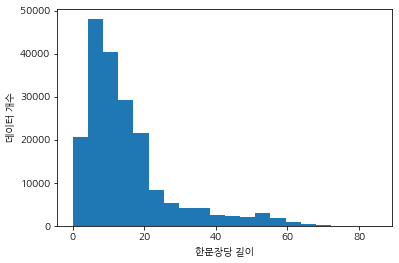

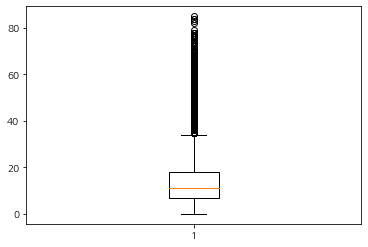

표준편차 +- 2범위내 데이터수: 182439 원래전체데이터대비비중: 93.51 %


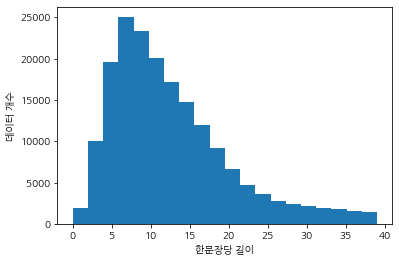

적절한 최대 문장 길이 >> pad_sequences maxlen:  39
word_to_index_앞쪽 10개 확인: [['', 3], ['.', 4], ['영화', 5], ['다', 6], ['고', 7], ['하', 8], ['을', 9], ['보', 10], [',', 11], ['게', 12]]
len(word_to_index) 9997
word_to_index_추가된 항목 재확인: [['금기', 9998], ['부셔', 9999], ['<BOS>', 0], ['<PAD>', 1], ['<UNK>', 2]]
<BOS>
3
.
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
8
<BOS>
보정완료 OK
len(word_to_index): 10000
X_train [[31, 70, 869, 38, 223, 19, 32, 723], [994, 503, 535, 662, 5, 117, 1591, 52, 894, 975, 14, 43, 376], [23, 201, 3]] 146026 <class 'int'>
X_train 내의 인덱스 type확인: float 0 int 2176140 str 0 etc 0 총개수 2176140
X_train: (146026, 39)
X_test: (49084, 39)
X_train 총개수: 146026 80%분리:  116820 20%분리: 29206
partial_X_train 116820 partial_y_train 116820
X_val 29206 y_val 29206


In [29]:
#3. 모델 구성을 위한 데이터 분석 및 가공
#(1) 데이터셋 내 문장 길이 분포

## 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
total_data_text_dist = [len(x) for x in total_data_text]
#print(total_data_text_dist)

mean = round(np.mean(total_data_text_dist),2)
std = round(np.std(total_data_text_dist),2)
max = np.max(total_data_text_dist)
min = np.min(total_data_text_dist)
min_count = len([x for x in total_data_text_dist if x == 0])
print("문장길이평균:",mean)
print("문장길이표준편차:",std)
print("문장길이Max:",max)
print("문장길이Min:",min)
print("문장길이 0개수:", min_count)

# 히스토그램 시각화: total_data
print(plt.rcParams['font.family'])
plt.rc('font',family='NanumGothic')
plt.hist(total_data_text_dist, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

# 박스플롯: total_data
plt.boxplot(total_data_text_dist)
plt.show()

#(2) 적절한 최대 문장 길이 지정: 39

## 적절한 최대 문장 길이 지정: (평균 + 표준편차*2)이내
total_data_text_dist_array = np.array(total_data_text_dist)
total_data_text_within_2std = total_data_text_dist_array[(total_data_text_dist_array <= mean + std*2) & (total_data_text_dist_array >= mean - std*2)]
print("표준편차 +- 2범위내 데이터수:", len(total_data_text_within_2std),
      "원래전체데이터대비비중:",round(len(total_data_text_within_2std)*100/len(total_data_text),2),"%")

# 히스토그램 시각화: total_data_text_within_2std
plt.hist(total_data_text_within_2std, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

max_length = int(mean + std*2)
print("적절한 최대 문장 길이 >> pad_sequences maxlen: ",int(max_length))

    
## 보정 및 최대길이에 맞추어 Padding

#(3) word_to_index 및 index_to_word 보정: 앞쪽 위치 0,1,2번에 3개 항목 입력

# word_to_index의 첫 인덱스위치에 '<BOS>' 있는지 확인
print("word_to_index_앞쪽 10개 확인:",[[key,value] for key,value in word_to_index.items()][:10] )
print("len(word_to_index)",len(word_to_index))   # 3개가 비어있슴

# <BOS>, <PAD>,  <UNK> 3항목에 인덱스 0,1,2  보정값 입력
word_to_index["<BOS>"] = int(0)
word_to_index["<PAD>"] = int(1)
word_to_index["<UNK>"] = int(2)  # unknown
print("word_to_index_추가된 항목 재확인:",[[key,value] for key,value in word_to_index.items()][-5:] )

# index_to_word 도 보정
index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])     # '<BOS>' 가 출력
print(word_to_index[''])  # 3 이 출력
print(index_to_word[4])     # '.' 가 출력

# 보정 후 x_train[0] 데이터 확인: 
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print(len(X_train[0]))
print(index_to_word[y_train[0]])
print("보정완료 OK")

#(4) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 및 max_length로 일정길이 맞춤
print("len(word_to_index):",len(word_to_index))
print("X_train", X_train[:3], len(X_train), type(X_train[0][0]))

# type 확인: train 내의 word index의 type check: 모두 int 임, 총개수 2,176,140개
floatlist = [];intlist = [];strlist = [];etclist = []
for X in X_train:
    for idx in X:
        if type(idx) == float:
            floatlist.append(idx)            
        elif type(idx) == int:
            intlist.append(idx)  
        elif type(idx) == str:
            strlist.append(idx)   
        else:
            etclist.append(idx)
print("X_train 내의 인덱스 type확인:","float",len(floatlist),"int",len(intlist),"str",len(strlist),
       "etc",len(etclist),"총개수", len(floatlist)+ len(intlist)+ len(strlist)+len(etclist)) # int만 총개수 2,176,140

# 숫자로 변환된 텍스트 데이터를 numpy array로 변경. 
X_train = np.array(X_train, dtype='object')
X_test = np.array(X_test, dtype='object')

## padding된 데이터: padding된 곳은 1 이 입력됨
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'], # <PAD> index 값 : 1
                                                       padding='pre',           # 성능향상위해 'pre'적용
                                                       maxlen=max_length)       # maxlen = 39
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'], # <PAD> index 값 : 1
                                                       padding='pre',           # 성능향상위해 'pre'적용
                                                       maxlen=max_length)       # maxlen = 39
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


## train data, vaoli data 분리 : 80:20
print("X_train 총개수:", len(X_train), "80%분리: ",int(len(X_train)*0.8), "20%분리:",len(X_train)-int(len(X_train)*0.8))
train_len = int(len(X_train)*0.8)
valid_len = len(X_train)-int(len(X_train)*0.8)

# validation set 20% 분리: 
X_val = X_train[:valid_len]   
y_val = y_train[:valid_len]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[valid_len:]  
partial_y_train = y_train[valid_len:]

print("partial_X_train",len(partial_X_train),"partial_y_train",len(partial_y_train))
print("X_val",len(X_val), "y_val",len(y_val))


* **LSTM모델구성 및  학습, 테스트**

In [32]:
#4. 모델 구성 및 validation set 구성

## Hyper param 설정
vocab_size = len(word_to_index)   # 어휘 사전의 크기(10,000개의 단어)

word_vector_dim = 16  # 워드 벡터의 차원 수
hidden_unit = 16
drop_rate = 0.2
epochs= 20 

## Hyper param 설정
vocab_size = len(word_to_index)   # 어휘 사전의 크기(10,000개의 단어)

word_vector_dim = 16  # 워드 벡터의 차원 수
hidden_unit = 16
drop_rate = 0.2
cnn_dense_hidden_unit = 8
cnn_filter = 7
cnn_maxpool = 4
epochs= 20 

#(1) LSTM 모델
## LSTM 모델

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.LSTM(hidden_unit)) 
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.Dense(hidden_unit, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

## LSTM모델구성 및  학습
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
history_lstm = model_lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

## test data 로 LSTM 모델 성능평가
## LSTM 모델 성능평가

print("  ")
print("test data 로 LSTM 모델 성능평가", "---"*30)
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)
print("results_lstm", results_lstm)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 162,401
Trainable params: 162,401
Non-trainable params: 0
________________________________________________

#### [평가] Mecab의 경우 LSTM test accuracy 84.55% 였슴(SentencePiece 84.32% 보다 큰차이는 아니나 더 우수함) 

####  (3) Okt

* **데이터 전처리,형태소분석,Tokenizer 함수생성 및 word_to_index, index_to_word 관련 함수생성**

In [33]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table(r'~/aiffel/sp_tokenizer/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_test.txt')

print("train_data",train_data.head(),train_data.shape)
print('-'*60)
print("test_data",test_data.head(),test_data.shape)

train_data          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1 (150000, 3)
------------------------------------------------------------
test_data         id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0 (50000, 3)


In [34]:
## 데이터로더
tokenizer = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words=10000

def load_data(train_data, test_data, num_words=num_words):
    ## 중복값 제거:  'document'컬럼의 중복값 제거,'label'컬럼은 0,1의 두개면 맞음
    #1. train_data
    print("train_data['document'].nunique()",train_data['document'].nunique())
    if train_data['document'].nunique() < len(train_data):
        train_data.drop_duplicates(subset=['document'], inplace=True) 
        print("train_data['label'].nunique()",train_data['label'].nunique())    
        print("중복제거후 len(train_data)",len(train_data))    
    #2. test_data    
    print("test_data['document'].nunique()",test_data['document'].nunique())
    if test_data['document'].nunique() < len(test_data):
        test_data.drop_duplicates(subset=['document'], inplace=True)
        print("test_data['label'].nunique()",test_data['label'].nunique())    
        print("중복제거후 len(test_data)",len(test_data))
    
    ## 결측치제거 : 1개라도 있으면, 해당행 전체 제거
    #1. train_data
    print("결측치 개수",train_data.isnull().sum())
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",train_data.isnull().any().any())    
    #2. test_data
    print("결측치 개수",test_data.isnull().sum())
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",test_data.isnull().any().any())
    
    ## 데이터 정제 
    # 한글과 숫자,공백(한개이상 공백은 한개로 축소),특수문자일부 !?,.^을 제외하고 제거:[^ㄱ-힣a-zA-Z0-9!?,.^\s]
    # --> 한글형태소기를 tokenizer로 쓸 경우에는 영어및 일부선택된 특수문자외에는 모두제거(..., - - 등도 제거)
    #1. train_data
    train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
    train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ") 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                         
    print("한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()",train_data.head())
    #2. test_data
    test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
    test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ") 
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                            
    print("한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()",test_data.head())
    # 데이터 정제후 빈 공백만 있는 문장의 경우 제거:  Nan 입력후 행제거
    #1. train_data
    train_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",train_data.isnull().any().any() )
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
    #2. test_data   
    test_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",test_data.isnull().any().any() )
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
    
    ## 한국어 토크나이저로 토큰화    
    # 1. train_data
    X_train = []
    for sentence in tqdm.tqdm(train_data['document']):
        tokenized = tokenizer.morphs(sentence) # morphs 형태소추출
        #print("tokenized", tokenized)
        tokenized_without_stopwords = [word for word in tokenized if not word in stopwords] # 불용어 제거
        X_train.append(tokenized_without_stopwords)
    print("X_train",X_train[:5],len(X_train))
    
    # 2. test_data
    X_test = []
    for sentence in tqdm.tqdm(test_data['document']):
        tokenized = tokenizer.morphs(sentence) # morphs 형태소추출
        #print("tokenized", tokenized)
        tokenized_without_stopwords = [word for word in tokenized if not word in stopwords] # 불용어 제거
        X_test.append(tokenized_without_stopwords)
    print("X_test",X_test[:5],len(X_test))
    
    ## word_to_index 구성: train only ???  train + test ??? 로 word vs index 매칭 ??? !!!!!!!!!!!!
    words = np.concatenate(X_train).tolist()  
    #words = np.concatenate(X_train).tolist() + np.concatenate(X_test).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)   #10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    ## X_Train, X_test 를 word_to_index의 index로 mapping
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 인덱스로 매칭된 데이터 확인
print("X_train[:5]",X_train[:5],"y_train[:5]",y_train[:5],"X_test[:5]",X_test[:5],"y_test[:5]",y_test[:5])
print('len( word_to_index)', len(word_to_index))

## 인덱스를 key로 word 반환 Dict 만들기
index_to_word = {index:word for word, index in word_to_index.items()}
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


train_data['document'].nunique() 146182
train_data['label'].nunique() 2
중복제거후 len(train_data) 146183
test_data['document'].nunique() 49157
test_data['label'].nunique() 2
중복제거후 len(test_data) 49158
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False
결측치 개수 id          0
document    1
label       0
dtype: int64


/tmp/ipykernel_3107/2495083662.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_3107/2495083662.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_3107/2495083662.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


결측치제거후 결측치 여부 False
한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()          id                                           document  label
0   9976970                                 아 더빙  진짜 짜증나네요 목소리      0
1   3819312                       흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                        교도소 이야기구먼  솔직히 재미는 없다 평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


/tmp/ipykernel_3107/2495083662.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_3107/2495083662.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_3107/2495083662.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()         id                                        document  label
0  6270596                                             굳 ㅋ      1
1  9274899                                                      0
2  8544678             뭐야 이 평점들은  나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                     지루하지는 않은데 완전 막장임  돈주고 보기에는       0
4  6723715  3만 아니었어도 별 다섯 개 줬을텐데  왜 3로 나와서 제 심기를 불편하게 하죠??      0
Nan 존재유뮤 True
Nan 존재유뮤 True


100%|██████████| 146026/146026 [04:37<00:00, 526.98it/s]


X_train [['아', '더빙', '진짜', '짜증나네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'], ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스런', '연기', '돋보였던', '영화', '!', '스파이더맨', '에서', '늙어', '보이기만', '했던', '커스틴', '던스트', '너무나도', '이뻐', '보였다']] 146026


100%|██████████| 49084/49084 [01:29<00:00, 548.99it/s]


X_test [['굳', 'ㅋ'], ['뭐', '야', '평점', '나쁘진', '않지만', '10', '점', '짜', '리', '더', '더욱', '아니잖아'], ['지루하지는', '않은데', '완전', '막장', '임', '돈', '주고', '보기', '에는'], ['3만', '아니었어도', '별', '다섯', '개', '줬을텐데', '왜', '3', '로', '나와서', '제', '심기', '불편하게', '하죠', '??'], ['음악', '주가', '된', ',', '최고', '음악', '영화']] 49084
X_train[:5] [[46, 435, 15, 6959, 649], [908, 436, 40, 597, 5, 197, 1558, 19, 965, 6130, 3], [376, 2870, 3, 6515, 8077, 3, 201, 10], [8742, 103, 3, 218, 56, 72, 21, 4411], [1055, 3, 24, 3, 19, 6516, 5, 12, 3065, 18, 5380, 3, 461, 3, 3, 1107, 3810, 4512]] y_train[:5] [0 1 0 0 1] X_test[:5] [[792, 80], [58, 154, 21, 4739, 1443, 69, 16, 1064, 880, 44, 778, 3696], [3, 2484, 85, 325, 107, 101, 378, 143, 252], [3, 3, 118, 2587, 98, 9936, 32, 99, 17, 605, 179, 3, 3, 6083, 165], [191, 3490, 140, 7, 23, 191, 5]] y_test[:5] [1 0 0 0 1]
len( word_to_index) 9997


* **데이터내 문장 Max_length설정, 보정, Padding 및 train data, valid data 분리**

문장길이평균: 12.16
문장길이표준편차: 10.08
문장길이Max: 79
문장길이Min: 0
문장길이 0개수: 318
['NanumGothic']


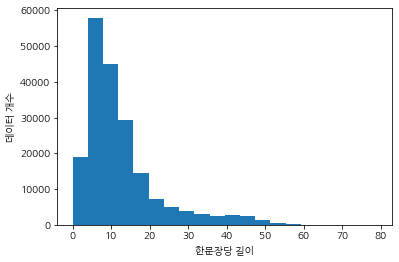

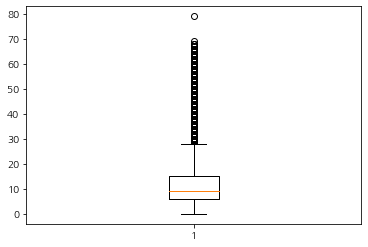

표준편차 +- 2범위내 데이터수: 182661 원래전체데이터대비비중: 93.62 %


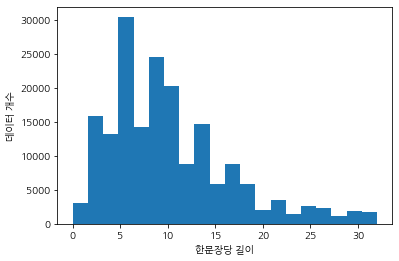

적절한 최대 문장 길이 >> pad_sequences maxlen:  32
word_to_index_앞쪽 10개 확인: [['', 3], ['.', 4], ['영화', 5], ['을', 6], [',', 7], ['?', 8], ['너무', 9], ['다', 10], ['정말', 11], ['!', 12]]
len(word_to_index) 9997
word_to_index_추가된 항목 재확인: [['예뻤다', 9998], ['배달', 9999], ['<BOS>', 0], ['<PAD>', 1], ['<UNK>', 2]]
<BOS>
3
.
더빙 진짜 짜증나네요 목소리
라벨:  0
5
<BOS>
보정완료 OK
len(word_to_index): 10000
X_train [[46, 435, 15, 6959, 649], [908, 436, 40, 597, 5, 197, 1558, 19, 965, 6130, 3], [376, 2870, 3, 6515, 8077, 3, 201, 10]] 146026 <class 'int'>
X_train 내의 인덱스 type확인: float 0 int 1777541 str 0 etc 0 총개수 1777541
X_train: (146026, 32)
X_test: (49084, 32)
X_train 총개수: 146026 80%분리:  116820 20%분리: 29206
partial_X_train 116820 partial_y_train 116820
X_val 29206 y_val 29206


In [35]:
#3. 모델 구성을 위한 데이터 분석 및 가공
#(1) 데이터셋 내 문장 길이 분포

## 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
total_data_text_dist = [len(x) for x in total_data_text]
#print(total_data_text_dist)

mean = round(np.mean(total_data_text_dist),2)
std = round(np.std(total_data_text_dist),2)
max = np.max(total_data_text_dist)
min = np.min(total_data_text_dist)
min_count = len([x for x in total_data_text_dist if x == 0])
print("문장길이평균:",mean)
print("문장길이표준편차:",std)
print("문장길이Max:",max)
print("문장길이Min:",min)
print("문장길이 0개수:", min_count)

# 히스토그램 시각화: total_data
print(plt.rcParams['font.family'])
plt.rc('font',family='NanumGothic')
plt.hist(total_data_text_dist, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

# 박스플롯: total_data
plt.boxplot(total_data_text_dist)
plt.show()

#(2) 적절한 최대 문장 길이 지정: 39

## 적절한 최대 문장 길이 지정: (평균 + 표준편차*2)이내
total_data_text_dist_array = np.array(total_data_text_dist)
total_data_text_within_2std = total_data_text_dist_array[(total_data_text_dist_array <= mean + std*2) & (total_data_text_dist_array >= mean - std*2)]
print("표준편차 +- 2범위내 데이터수:", len(total_data_text_within_2std),
      "원래전체데이터대비비중:",round(len(total_data_text_within_2std)*100/len(total_data_text),2),"%")

# 히스토그램 시각화: total_data_text_within_2std
plt.hist(total_data_text_within_2std, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

max_length = int(mean + std*2)
print("적절한 최대 문장 길이 >> pad_sequences maxlen: ",int(max_length))

    
## 보정 및 최대길이에 맞추어 Padding

#(3) word_to_index 및 index_to_word 보정: 앞쪽 위치 0,1,2번에 3개 항목 입력

# word_to_index의 첫 인덱스위치에 '<BOS>' 있는지 확인
print("word_to_index_앞쪽 10개 확인:",[[key,value] for key,value in word_to_index.items()][:10] )
print("len(word_to_index)",len(word_to_index))   # 3개가 비어있슴

# <BOS>, <PAD>,  <UNK> 3항목에 인덱스 0,1,2  보정값 입력
word_to_index["<BOS>"] = int(0)
word_to_index["<PAD>"] = int(1)
word_to_index["<UNK>"] = int(2)  # unknown
print("word_to_index_추가된 항목 재확인:",[[key,value] for key,value in word_to_index.items()][-5:] )

# index_to_word 도 보정
index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])     # '<BOS>' 가 출력
print(word_to_index[''])  # 3 이 출력
print(index_to_word[4])     # '.' 가 출력

# 보정 후 x_train[0] 데이터 확인: 
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print(len(X_train[0]))
print(index_to_word[y_train[0]])
print("보정완료 OK")

#(4) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 및 max_length로 일정길이 맞춤
print("len(word_to_index):",len(word_to_index))
print("X_train", X_train[:3], len(X_train), type(X_train[0][0]))

# type 확인: train 내의 word index의 type check: 모두 int 임, 총개수 2,176,140개
floatlist = [];intlist = [];strlist = [];etclist = []
for X in X_train:
    for idx in X:
        if type(idx) == float:
            floatlist.append(idx)            
        elif type(idx) == int:
            intlist.append(idx)  
        elif type(idx) == str:
            strlist.append(idx)   
        else:
            etclist.append(idx)
print("X_train 내의 인덱스 type확인:","float",len(floatlist),"int",len(intlist),"str",len(strlist),
       "etc",len(etclist),"총개수", len(floatlist)+ len(intlist)+ len(strlist)+len(etclist)) # int만 총개수 2,176,140

# 숫자로 변환된 텍스트 데이터를 numpy array로 변경. 
X_train = np.array(X_train, dtype='object')
X_test = np.array(X_test, dtype='object')

## padding된 데이터: padding된 곳은 1 이 입력됨
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'], # <PAD> index 값 : 1
                                                       padding='pre',           # 성능향상위해 'pre'적용
                                                       maxlen=max_length)       # maxlen = 39
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'], # <PAD> index 값 : 1
                                                       padding='pre',           # 성능향상위해 'pre'적용
                                                       maxlen=max_length)       # maxlen = 39
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


## train data, vaoli data 분리 : 80:20
print("X_train 총개수:", len(X_train), "80%분리: ",int(len(X_train)*0.8), "20%분리:",len(X_train)-int(len(X_train)*0.8))
train_len = int(len(X_train)*0.8)
valid_len = len(X_train)-int(len(X_train)*0.8)

# validation set 20% 분리: 
X_val = X_train[:valid_len]   
y_val = y_train[:valid_len]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[valid_len:]  
partial_y_train = y_train[valid_len:]

print("partial_X_train",len(partial_X_train),"partial_y_train",len(partial_y_train))
print("X_val",len(X_val), "y_val",len(y_val))

#### LSTM모델구성 및 학습, 테스트

In [36]:
#4. 모델 구성 및 validation set 구성

## Hyper param 설정
vocab_size = len(word_to_index)   # 어휘 사전의 크기(10,000개의 단어)

word_vector_dim = 16  # 워드 벡터의 차원 수
hidden_unit = 16
drop_rate = 0.2
cnn_dense_hidden_unit = 8
cnn_filter = 7
cnn_maxpool = 4
epochs= 20 

## Hyper param 설정
vocab_size = len(word_to_index)   # 어휘 사전의 크기(10,000개의 단어)

word_vector_dim = 16  # 워드 벡터의 차원 수
hidden_unit = 16
drop_rate = 0.2
cnn_dense_hidden_unit = 8
cnn_filter = 7
cnn_maxpool = 4
epochs= 20 

#(1) LSTM 모델
## LSTM 모델

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.LSTM(hidden_unit)) 
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.Dense(hidden_unit, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

## LSTM모델구성 및  학습
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
history_lstm = model_lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

## test data 로 LSTM 모델 성능평가
## LSTM 모델 성능평가

print("  ")
print("test data 로 LSTM 모델 성능평가", "---"*30)
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)
print("results_lstm", results_lstm)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 162,401
Trainable params: 162,401
Non-trainable params: 0
________________________________________________

* **[평가] Okt 의 경우 LSTM test accuracy 83.27% 였슴(Mecab 84.55% 및 Unigram SentencePiece 84.32% 보다 낮음)**

## 4. 종합비교

* 데이터 전처리 관련 공통사항: 
SentencePiece 는 전처리가 필요없다고 dkffuwu dlTsmsep, 중복문장제거가 필요하였고, 결측치 처리가 않될 경우 오유가 발생하는등 기본적인 전처리가 필요하du,, Konlpy의 Mecab, Okt에서 하는 전처리에서처럼, 중복문장제거, 결측치처리, 구두점및특수문자등 3가지 전처리는 공통적으로 하였슴 

* 성능평가모델은 공통적으로 LSTM으로 썼으며, 모델 아키텍쳐와 손실함수, 옵티마이저, 하이퍼파람등 모두 동일하게 설정해서, 동일 기준으로 비교하였슴

Okt 의 경우 LSTM test accuracy 83.27% 였슴(Mecab 84.55% 및 Unigram SentencePiece 84.32% 보다 낮음)
 
#### (1) SetencePiece 평가
* Unigram 모델 성능:  test accuracy 84.32%   
* Bpe 모델 성능:  test accuracy 83.64%  (별도 깃허브 링크:  https://github.com/lkh-7/first-repository/blob/master/%5BGDeep%5D02_%5Bsp_tokenizer%5D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%A9%8B%EC%A7%84%20%EB%8B%A8%EC%96%B4%EC%82%AC%EC%A0%84%20%EB%A7%8C%EB%93%A4%EA%B8%B0_Project_%EC%A0%9C%EC%B6%9C%EC%A4%80%EB%B9%84%EC%9A%A9_SPM_Bpe_ONLY.ipynb) 

* (특이점) SetencePiece 모델은 한국어에 적용할 경우 불용어처리기능이 없었는데, 성능이 좋은 편이었으며, 데이터 전처리가 필요없다고,알려진 바와 다르게, 중복문장처리, 결측치제거, 특수문자처리등 기본적인 전처리가 필요했슴

* Unigram 모델이 더 우수 


#### (2) KoNLPY 평가
* Mecab 모델 성능:  test accuracy 84.55%   
* Okt 모델 성능:  test accuracy 83.27%  

* Mecab 모델이 더 우수

#### (3) 종합평가
* **전체중에서, Mecab 가 제일 우수**했슴, 2위는 **Unigram방식의  SetencePiece**


## 회고

본 프로젝트는 LMS교재 Explore 8번에서 네이버영화리뷰 감성분석을 할때, 텍스트를 벡터화하는 단계에서, 사용해보았던 KoNLPy의 Mecab외에, 이번에 새롭게 배운 SentencePiece를 적용해보고, 각가의 특징과 사용법을 배우면서,, 각각의 성능을 비교해 보기 위한 프로젝트입니다.

먼저, 단어사전을 만드는 대상 Corpus를 결정해야하는데, 여러기준으로 비교해 보다가, 교재에서 사용했던 Korea-english 병행 Corpus를 사용하려다가
Korea-english 병행 Corpus의 전처리된 문장개수가 77,000여개로,
네이버영화리뷰의 train data 전처리후 Corpus 문장개수 146,000개의 절반수준밖에 않되는 수준이라서,
네이버의 Train data Corpus를 대상으로 단어사전을 만들기로 하였습니다.

**(1) Unigram**    

그리고는 먼저 SentencePiece의 Unigram과 bpe를 성능비교하기로 하고서, 먼저 Unigram을 시작하였습니다.
데이터 전처리가 필요없다던 SentencePiece에서 중복치제거, 결측치제거, 특수기호나 구두점등의 처리를 해야 오류가 않나고, 학습이 잘었습니다. 전처리가 필없다는 이야기는 영어의 경우에 해당되는가 봅니다.
그리고, SentencePiece에는 불용어를 처리하는 기능을 찾아보아도 없었습니다.
그럼에도 불구하고 SentencePiece를 많이 쓴다는 이야기는 성능이 좋다는 이야기일텐데, 비교해볼 충분한 이유가 됩니다.

vocab_size는 10000개로 해서, 1차 SentencePiec Train을 통해서, 생성된 토큰으로, 적절한 크기의 maxlen 42개를 구한후, maxlen 을 산입하여, 2차로 sp_tokenize_withPadding(s, corpus, maxlen)함수를 통해서, SentencePiec Train을 다시 해서, 정식으로 vocab_size 10000개의 단어장과 Word_index, Index_Word를  만들었습니다.
학습된 Unigram 모델의 spm.SentencePieceProcessor()로 Train data를 벡터화완료하고, 마찬가지로 Test data의 벡터화도 완료하였습니다. 
그리고, Train data를 8;2의 비율로 Valid data를 분리하였습니다.

모델은 LSTM모델을 사용하였고, word_vector_dim = 16, hidden_unit = 16, drop_rate = 0.2, epochs= 20 로 고정시켰고, 옵티마이저는 adam, 손실함수 'binary_crossentropy 를 사용하였고, 비교를 위해 다른 모델에서도 동일한 구조를 사용할 예정입니다.
  
학습후에 Test data로 성능테스트를 했는데, 84.32% 였습니다.

**(2) Bpe**   

model Type을 'bpe'로 바꾸어서, 상기의 작업과정과 동일한 과정을 통해서, 성능테스트를 했는데, 83.64%였습니다.   
이는 Unigram보다 성능이 낮았습니다.   

Bpe 작업파일 링크: https://github.com/lkh-7/first-repository/blob/master/%5BGDeep%5D02_%5Bsp_tokenizer%5D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%A9%8B%EC%A7%84%20%EB%8B%A8%EC%96%B4%EC%82%AC%EC%A0%84%20%EB%A7%8C%EB%93%A4%EA%B8%B0_Project_%EC%A0%9C%EC%B6%9C%EC%A4%80%EB%B9%84%EC%9A%A9_SPM_Bpe_ONLY.ipynb

**(3) KoNLPy 의 Mecab**   

[Explore 8] 네이버영화리뷰 분류에서 했던 과정과 같은 과정을 거치되, 위의 LSTM모델과 동일 구조와 하이퍼파람으로 성능테스트해 본 결과 Test Accuracy는 84.55% 였습니다.

**(4) KoNLPy 의 Okt**   

상기 (3)과 동일 과정을 거쳐서, 성능테스트해 본 결과 Test Accuracy는 83.27% 였습니다.

**(5) 종합평가**  

전체중에서, Mecab 가 우수했고, 2위는 Unigram방식의 SetencePiece, 3위는 bpe방식의 SetencePiece,
4위가 Okt 였습니다.

**결론적**으로, 한국어는 한국어형태소분석기가 더 잘맞고, 그중 Mecab이 가장 우수하며, Unigram 방식의 SencePiece
도 우수한 편이었어서, **한국어만으로된 문서들을 처리할때는 한국어형태소분석기 Mecab**을 쓰고,
**한국어와 영어를 비슷한 비중으로 병행 사용**하는 문서들을 처리할때는 **Unigram 방식의 SencePiece**를 사용하는 것이 좋겠다는 생각입니다.(문서집합에따라 적용상황이 다소 다를수도 물론 있지만) 









#### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?

코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?

SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.

3. SentencePiece의 성능을 다각도로 비교분석하였는가?

SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.
프로젝트 업로드 (URL)

